In [14]:
from random import random
from math import sqrt, log, cos, pi, exp
import matplotlib.pyplot as plt

In [15]:
def box_muller_rand():
    return sqrt(-2 * log(random())) * cos(2 * pi * random())

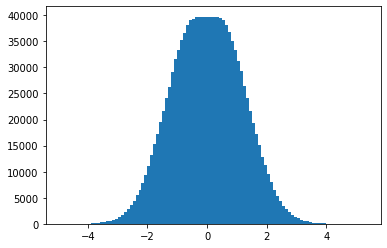

In [16]:
bins = { }
for i in range(1000000):
    num = round(box_muller_rand(), 1)
    bins[num] = bins.get(num, 0) + 1

plt.bar(bins.keys(), bins.values())
plt.show()

In [33]:
def create_path(initial, time, steps, volatility, riskfree):
    dt = time / steps
    sdt = sqrt(dt)

    path = []
    current = initial
    for i in range(steps):
        path.append(current)
        current = current * exp((riskfree - 0.5 * volatility * volatility) * dt + sdt * volatility * box_muller_rand())

    return path

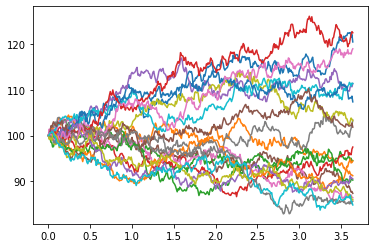

In [34]:
paths = []
x = [x / 100 for x in range(365)]
for i in range(20):
    paths.append(create_path(100, 1, 365, 0.1, 0.01))
    plt.plot(x, paths[-1])

In [60]:
def price_option(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=None, knockout=None, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1

    premiums = []
    for i in range(simulations):
        path = create_path(spot, time, time * steps_per_unit, volatility, risk_free)
        if knockin and knockin > spot and max(path) < knockin: # Up and In
            premiums.append(0)
        elif knockin and knockin < spot and min(path) > knockin: # Down and In
            premiums.append(0)
        elif knockout and knockout < spot and min(path) < knockin: # Down and Out
            premiums.append(0)
        elif knockout and knockout > spot and max(path) > knockout: # Up and Out
            premiums.append(0)
        else:
            premiums.append(max(0, cp * (path[-1] - strike)))

    return sum(premiums) / simulations * exp(-time * risk_free)

In [63]:
spot=100
strike=105
vol=0.2
risk_free=0.05

call = price_option(strike, spot, 1, vol, risk_free)
call

8.080665969358542

In [ ]:
def black_scholes(strike, spot, time, volatility, risk_free, call_or_put='c'):
    

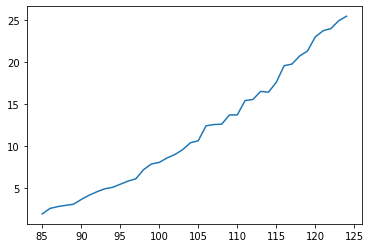

In [64]:
x=[]
y=[]
for spot in range(85, 125, 1):
    x.append(spot)
    y.append(price_option(strike, spot, 1, vol, risk_free))

plt.plot(x, y)